# 数据探索EDA

本次作业以赵小曼、范举老师 **<a href="https://mp.weixin.qq.com/s/0mB03Zp0jaI9uOdx5cbCkg">“1183位求助者的数据画像：不是弱者，而是你我”</a>** 的文章为基础，现提供部分数据供大家练习。       
本次作业需要完成     
1. 文章中第1部分、第2部分的内容，主要为数据探索及可视化，并且进行一定的分析。     
2. 除文中明确给出的任务外，请自选一个角度进行数据分析。

- **姓名**: 徐慧聪 
- **学号**: 2019202363
***

## 知识点回顾与补充
1. 回顾 百度API 的使用。
2. 回归 正则表达式 的使用。
3. 补充备用的计算球面两点距离的公式。

### 计算球面距离的Haversine公式
$$
\text { haversin }\left(\frac{d}{R}\right)=\operatorname{haversin}\left(\varphi_{2}-\varphi_{1}\right)+\cos \left(\varphi_{1}\right) \cos \left(\varphi_{2}\right) \operatorname{haversin}(\Delta \lambda)
$$
其中
$
\operatorname{haversin}(\theta)=\sin ^{2}(\theta / 2)=(1-\cos (\theta)) / 2
$
- R为地球半径，可取平均值 6371km；
- φ1, φ2 表示两点的纬度；
- Δλ 表示两点经度的差值。

当然，建议使用百度 API 计算两点距离，此公式仅作为备用（万一配额用完了...

In [64]:
def haversine_distance(lat1:float, long1:float, lat2:float, long2:float)->float:
    """
    Haversine公式：计算球面距离
    Params:
        lat1(float): 点1纬度
        long1(float): 点1经度
        lat2(float): 点2纬度
        long2(float): 点2经度
    Return:
        float: 单位为km
    """
    from math import radians, sin, cos, atan2, sqrt
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    a = sin((lat1-lat2)/2)**2 + cos(lat1)*cos(lat2)*(sin((long1-long2)/2)**2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return 6371 * c

下面进入实验正文



## 导入库和数据
1. 所有导入操作必须限制在以下两个 Cell 中 
2. 可以导入第三方的包，导入后请在提交的报告中给以必要说明
3. 可以导入第三方的数据，导入后请在提交的报告中给以必要说明

In [2]:
### 在此处导入 Package
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import jieba
import sklearn
import scipy
import math
import requests

In [56]:
### 在此处导入 Dataset
weibodata = pd.read_excel("weibo.xlsx")
lianjia_data = pd.read_excel("new_lianjia.xlsx")
hospital_data = pd.read_excel("poi_hospital.xlsx")
with open("sos_stopwords.txt",encoding="utf-8") as f: # 导入停用词，如有需要可以自行补充
    stopwords = f.read().split()
print(stopwords)

['患者', '我们', '现在', '开始', '结果', '已经', '求助', '目前', '一直', '情况', '出现', '显示', '武汉市', '武汉', '大家', '转发', '只能', '办法', '其他', '一个', '联系人', '超话', '今天', '但是', '得到', '全文缺失', 'nil', 'NIL']


## 数据清洗与合并
1. 此处的数据清洗为初步的通用的清洗，建议在后续具体操作中视情况进一步清洗。
2. 此处的数据合并**非常重要**! 4k+ 的微博中实际含有 1k+ 求助者，后续分析基于求助者。
    1. 简单起见，约定使用 ```求助者姓名ID``` 为依据
    2. 合并时，各列保留尽可能多的信息（因为不同微博转发内容长度可能不同）

In [54]:
### 初步清洗：可以对数据中的字符串、离散值、空值等做处理
weibodata.head()

name   age    city        addr    user    pubdate  \
0    72  52.0    湖北武汉  长山社区万科嘉园小区   641.0  2020/2/17   
1    72  51.0    湖北武汉  长山社区万科嘉园小区  1544.0  2020/2/17   
2    23  76.0  武汉市洪山区   东湖御院 红星社区  1743.0  2020/2/13   
3  1227  52.0      武汉   云顶居，清水源社区  2319.0   2020/2/4   
4  1227  47.0      武汉   云顶居，清水源社区  2319.0   2020/2/5   

                     pubtime  \
0  0 days 12:09:09.000000000   
1  0 days 10:09:54.000000000   
2  0 days 23:44:23.000000000   
3  0 days 21:58:34.000000000   
4  0 days 14:23:47.000000000   

                                             quanwen  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  ，51岁，9个月前同济肾移植时有肺部并发症。冬季流感多发，1月15日发烧，按主治医生要求吃感...   
4                                                NaN   

                                  biaoti  link_lianjia_score user_gender  \
0                   卵巢肿瘤晚期，春节前已完成一个疗程的化?            1.061390           男   
1                  卵巢肿瘤晚期，春节前已完成一个疗程的化疗?            1.061390           女   
2      为肾衰透析病人，原透析医院为湖北省中医院光谷院区，1月31日有发?            1.336617           男   
3              ，51岁，9个月前同济肾移植时有肺部并发症。冬季?           10.000000           男   
4  ，51岁，9个月前肾移植时有肺部并发症。冬季流感多发，1月15日发烧，吃?           10.000000           男   

  user_province user_city  
0            北京        未知  
1            其他        不限  
2            其他        不限  
3            未知        未知  
4            未知        未知

In [55]:
weibodata.describe()

name          age         user  link_lianjia_score
count  4961.000000  4841.000000  4955.000000         4961.000000
mean    624.124572    58.150176  1194.066801            8.528909
std     453.988660    16.491858   693.997349            3.284598
min       0.000000     0.000000     0.000000           -1.000000
25%     270.000000    44.000000   586.500000           10.000000
50%     534.000000    61.000000  1207.000000           10.000000
75%    1010.000000    71.000000  1756.500000           10.000000
max    1484.000000   100.000000  2402.000000           10.000000

In [56]:
weibodata.drop(['user','user_gender','user_province','user_city'],axis=1,inplace=True)

### 以name进行排序,文字量大的放在前面
### 构建列表，使用每一个name的均值
### 去重合并
### 根据列表进行修改合并结果

In [57]:
weibodata.sort_values(by=['name','quanwen','addr','biaoti'],axis=0,ascending=[True,False,False,False],inplace=True)
weibodata.reset_index(inplace=True)

In [58]:
Wbage=[]

In [59]:
for i in range(0,1485):
    tmp=weibodata.loc[weibodata['name']==i]
    Wbage.append(tmp['age'].mean())
print(Wbage)

[70.59244532803181, 43.0, 62.0, 10.0, 36.5, 66.0, 65.66666666666667, 27.0, 42.0, 60.0, 70.0, 54.666666666666664, 53.5, 30.0, 66.0, 53.0, 88.0, 68.5, 57.0, 46.0, 44.0, 57.0, 78.0, 76.0, 70.0, 63.0, nan, 78.0, 55.0, 78.0, 86.0, 80.0, 59.6, 70.5, 35.5, nan, 49.0, 58.666666666666664, 35.0, 32.0, 70.0, 66.2, 77.0, 63.0, 75.0, 66.25, 29.0, 54.0, 65.22222222222223, 59.5, 72.0, 32.0, 60.0, 41.5, 63.5, 74.0, 29.5, 48.666666666666664, 77.20833333333333, 2.6666666666666665, 70.5, 100.0, 68.2, 60.333333333333336, 38.0, 58.2, 59.0, 58.0, 59.0, 72.0, 39.0, 71.0, 51.5, 63.0, 78.5, 77.0, 85.0, 69.0, 72.4, 24.0, 78.0, 42.666666666666664, 76.0, 42.0, 83.0, 82.0, 31.0, 61.0, 46.5, 46.0, 72.0, 76.75, 60.8125, 55.0, 40.0, 37.25, 71.5, 55.5, 30.5, 63.0, 45.0, 81.0, 47.666666666666664, 54.0, 71.25, 55.0, 84.0, 58.333333333333336, 64.42857142857143, 35.27272727272727, 60.0, 44.666666666666664, 57.142857142857146, 49.0, 54.0, 82.0, 84.0, 67.8, 72.0, 38.25, 68.0, 69.0, 84.5, 70.0, 56.333333333333336, 61.0, 67.0

In [60]:
weibodata.head()

index  name   age city     addr   pubdate                    pubtime  \
0   3283     0  73.0   武汉  硚口区汉口春天  2020/2/8  0 days 20:38:03.000000000   
1   3161     0  71.0   武汉  硚口区汉口春天  2020/2/8  0 days 21:03:54.000000000   
2   3131     0  71.0   武汉  硚口区汉口春天  2020/2/8  0 days 21:08:47.000000000   
3   3147     0  71.0   武汉  硚口区汉口春天  2020/2/8  0 days 21:19:46.000000000   
4   3116     0  68.0   武汉    硚口区汉口  2020/2/8  0 days 22:28:28.000000000   

                                             quanwen  \
0  和分别于21号和22号出现新冠症状，在家隔离观察两天后越发严重寻求治疗，但医院爆满27号才做...   
1  和分别于21号和22号出现新冠症状，在家隔离观察两天后越发严重寻求治疗，但医院爆满27号才做...   
2  和分别于21号和22号出现新冠症状，在家隔离观察两天后越发严重寻求治疗，但医院爆满27号才做...   
3  和分别于21号和22号出现新冠症状，在家隔离观察两天后越发严重寻求治疗，但医院爆满27号才做...   
4  和分别于21号和22号出现新冠症状，在家隔离观察两天后越发严重寻求治疗，但医院爆满27号才做...   

                          biaoti  link_lianjia_score  
0            和分别于21号和22号出现新冠症状，?                10.0  
1            和分别于21号和22号出现新冠症状，?                10.0  
2             和分别于21号和22号出现新冠症状?                10.0  
3             和分别于21号和22号出现新冠症状?                10.0  
4  #肺炎患者求助[超话]#【年龄】71岁，43岁【所在城市】                10.0

In [61]:
weibodata.drop_duplicates(subset=['name'],keep='first',inplace=True)
weibodata.reset_index(inplace=True)
weibodata.describe()

level_0        index         name          age  link_lianjia_score
count  1485.000000  1485.000000  1485.000000  1445.000000         1485.000000
mean   2872.620875  2353.456566   742.000000    59.139792            7.806646
std    1301.595544  1466.563768   428.826888    15.951662            3.801770
min       0.000000     1.000000     0.000000     3.000000           -1.000000
25%    2075.000000  1195.000000   371.000000    50.000000            2.805690
50%    2983.000000  2159.000000   742.000000    60.000000           10.000000
75%    3965.000000  3107.000000  1113.000000    70.000000           10.000000
max    4951.000000  4956.000000  1484.000000   100.000000           10.000000

In [62]:
weibodata['age'].update(Wbage)
weibodata.head()
weibodata.describe()

level_0        index         name          age  link_lianjia_score
count  1485.000000  1485.000000  1485.000000  1451.000000         1485.000000
mean   2872.620875  2353.456566   742.000000    58.980867            7.806646
std    1301.595544  1466.563768   428.826888    15.985608            3.801770
min       0.000000     1.000000     0.000000     2.666667           -1.000000
25%    2075.000000  1195.000000   371.000000    49.333333            2.805690
50%    2983.000000  2159.000000   742.000000    60.500000           10.000000
75%    3965.000000  3107.000000  1113.000000    70.000000           10.000000
max    4951.000000  4956.000000  1484.000000   100.000000           10.000000

In [63]:
#进行age数据空值的填充
weibodata['age'].fillna(59,inplace=True)
weibodata['quanwen'].fillna('全文缺失',inplace=True)
weibodata['city'].fillna('武汉市',inplace=True)
weibodata['addr'].fillna('武汉市',inplace=True)
weibodata['age'].update(weibodata['age'].round())
weibodata.head(30)

level_0  index  name   age        city                        addr  \
0         0   3283     0  71.0          武汉                     硚口区汉口春天   
1       511   4206     1  43.0         武汉市                 硚口区 古田路红星佳苑   
2       513   2910     2  62.0          武汉                    武胜路名仕阁小区   
3       515    332     3  10.0         武汉市               中南路付家坡小区付家坡二路   
4       516    215     4  36.0         武汉市                    东西湖区恒大嘉园   
5       518   2756     5  66.0          武汉               武汉市硚口区荣华街道金利屋   
6       520   1622     6  66.0         武汉市                 江岸区，一元街同福社区   
7       523   2289     7  27.0          武汉  洪山区白沙洲大道万科金色城市小区，洪山区金色城市社区   
8       524   1488     8  42.0          武汉                   江夏区纸坊世纪花园   
9       525   1502     9  60.0          武汉                         一元街   
10      526   4791    10  70.0          武汉               武昌区徐家棚秦园路环卫小区   
11      530   1336    11  55.0          武汉                  汉阳区建桥街车站社区   
12      533   1723    12  54.0          武汉                        宝岛公寓   
13      535   1836    13  30.0          武汉                   汇龙花园、胜华社区   
14      536   4388    14  66.0          武汉                   红卫路社区碧园小区   
15      537   1661    15  53.0  武汉兴业路百步亭花园                        名流世家   
16      538   2186    16  88.0          武汉                  江汉区泛海国际松海园   
17      539   1295    17  68.0        湖北武汉            武汉市汉阳区钟家村琴台社区琴台村   
18      541   4771    18  57.0      武汉市江夏区                   纸坊街杨家湾还建楼   
19      543   2071    19  46.0          武汉                  江岸区四唯街麟趾新村   
20      548   1574    20  44.0          武汉                  江岸区四唯街六合社区   
21      550   2683    21  57.0          武汉                青山区钢都花园126街坊   
22      551    630    22  78.0   湖北省武汉市武昌区                黄鹤楼街道彭刘杨社区乃园   
23      553      2    23  76.0      武汉市洪山区                   东湖御院 红星社区   
24      554   2327    24  70.0          武汉                      长江紫都2期   
25      556   4244    25  63.0          武汉                 硚口区建设大道营房北村   
26      558    631    26  59.0         武汉市       武汉市武昌区黄鹤楼街道西厂口社区（彭刘杨路   
27      559   1971    27  78.0          武汉                     江岸区石桥社区   
28      560   2546    28  55.0          武汉                  沙湖港湾2期和平社区   
29      563    626    29  78.0          武汉                        彭刘杨路   

      pubdate                    pubtime  \
0    2020/2/8  0 days 20:38:03.000000000   
1   2020/2/11  0 days 12:54:21.000000000   
2    2020/2/8  0 days 18:23:33.000000000   
3   2020/2/16  0 days 19:49:03.000000000   
4    2020/2/5  0 days 14:56:56.000000000   
5    2020/2/6  0 days 22:30:30.000000000   
6    2020/2/9  0 days 01:12:08.000000000   
7    2020/2/9  0 days 21:16:27.000000000   
8   2020/2/10  0 days 12:53:31.000000000   
9    2020/2/7  0 days 14:18:59.000000000   
10   2020/2/5  0 days 00:37:13.000000000   
11   2020/2/8  0 days 04:55:19.000000000   
12   2020/2/4  0 days 17:37:12.000000000   
13   2020/2/5  0 days 15:30:35.000000000   
14   2020/2/6  0 days 06:45:58.000000000   
15   2020/2/5  0 days 12:48:33.000000000   
16   2020/2/8  0 days 16:47:35.000000000   
17  2020/2/11  0 days 08:40:39.000000000   
18  2020/2/10  0 days 15:01:19.000000000   
19   2020/2/6  0 days 09:47:57.000000000   
20  2020/2/11  0 days 08:41:05.000000000   
21  2020/2/11  0 days 10:34:55.000000000   
22  2020/2/14  0 days 10:16:20.000000000   
23  2020/2/13  0 days 23:44:23.000000000   
24   2020/2/4  0 days 17:48:37.000000000   
25   2020/2/8  0 days 08:05:24.000000000   
26   2020/2/9  0 days 23:20:06.000000000   
27  2020/2/12  0 days 19:28:29.000000000   
28  2020/2/10  0 days 22:31:01.000000000   
29  2020/2/10  0 days 01:53:26.000000000   

                                              quanwen  \
0   和分别于21号和22号出现新冠症状，在家隔离观察两天后越发严重寻求治疗，但医院爆满27号才做...   
1   患者母亲1月31日起开始发烧，患者一直陪伴母亲去普爱医院做测试，排队等候治疗。每天清早去医院...   
2   病人是我妈妈她症状为咳嗽不止全身乏力恶心反胃无法进食呼吸急促去医院拍了ct双肺感染有一半肺即...   
3   全家感染，奶奶和姑妈因为住不上院已经离世，妈妈确诊前天被方舱医院收治，在隔离点，2月16号C...   
4                                  双肺上叶可见斑片及磨玻璃状高密度影。   
5 

In [64]:
weibodata.to_excel("Wbdata.xlsx",index=False,header=True)

In [4]:
weibodata = pd.read_excel("Wbdata.xlsx")
weibodata.drop(['level_0','index','pubdate','pubtime','link_lianjia_score'],axis=1).to_csv('task0.csv',encoding='utf-8')

### 去重合并：姓名为标准， 请保留尽可能多的信息。

### 使用修改后的文件进行数据处理

## 数据分析及结论

### 基础信息统计

**Taks1:** 求助患者的年龄

1. 可视化:绘制**直方图**展示结果，数据分组方法自定。
2. 统计量:平均值、方差、中位数，结果保留两位小数。


In [65]:
weibodata = pd.read_excel("Wbdata.xlsx")

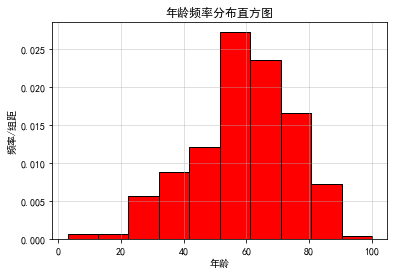

In [66]:
### 
plt.rcParams['font.sans-serif']=[u'SimHei']
plt.hist(weibodata['age'],bins=10,density=True,facecolor='red',edgecolor='black',rwidth=8)
plt.grid(alpha = 0.5)
plt.xlabel('年龄')
plt.ylabel('频率/组距')
plt.title('年龄频率分布直方图')
plt.show()

In [67]:
print('平均年龄：',weibodata['age'].mean())
print('方差：',weibodata['age'].var())
print('中位数：',weibodata['age'].median())

平均年龄： 58.97306397306397
方差： 249.17178070008254
中位数： 60.0


**Task2:** 求助微博的词频  
        
1. 删除：冗余的停用词， 如 '武汉'   
2. 合并：'父亲' 和 '爸爸' (自行构建)   
3. 展示： Top30 的词语及其词频。    
4. 绘图:  形式自选(如词云图),**不强制**。     

In [68]:
weibodata.head()

level_0  index  name  age city           addr    pubdate  \
0        0   3283     0   71   武汉        硚口区汉口春天   2020/2/8   
1      511   4206     1   43  武汉市    硚口区 古田路红星佳苑  2020/2/11   
2      513   2910     2   62   武汉       武胜路名仕阁小区   2020/2/8   
3      515    332     3   10  武汉市  中南路付家坡小区付家坡二路  2020/2/16   
4      516    215     4   36  武汉市       东西湖区恒大嘉园   2020/2/5   

                     pubtime  \
0  0 days 20:38:03.000000000   
1  0 days 12:54:21.000000000   
2  0 days 18:23:33.000000000   
3  0 days 19:49:03.000000000   
4  0 days 14:56:56.000000000   

                                             quanwen  \
0  和分别于21号和22号出现新冠症状，在家隔离观察两天后越发严重寻求治疗，但医院爆满27号才做...   
1  患者母亲1月31日起开始发烧，患者一直陪伴母亲去普爱医院做测试，排队等候治疗。每天清早去医院...   
2  病人是我妈妈她症状为咳嗽不止全身乏力恶心反胃无法进食呼吸急促去医院拍了ct双肺感染有一半肺即...   
3  全家感染，奶奶和姑妈因为住不上院已经离世，妈妈确诊前天被方舱医院收治，在隔离点，2月16号C...   
4                                 双肺上叶可见斑片及磨玻璃状高密度影。   

                            biaoti  link_lianjia_score  
0              和分别于21号和22号出现新冠症状，?           10.000000  
1  患者母亲1月31日起开始发烧，患者一直陪伴母亲去普爱医院做测?            1.646069  
2           病人是我妈妈她症状为咳嗽不止全身乏力恶心反?           10.000000  
3                    全家感染，奶奶和姑妈因为?            2.289911  
4              双肺上叶可见斑片及磨玻璃状高密度影。?           10.000000

In [69]:
###
import jieba
with open("sos_stopwords.txt",encoding="utf-8") as f: # 导入停用词，如有需要可以自行补充
    stopwords = f.read().split()
def cut_word(word):
    cw = jieba.lcut(word)
    cw = [string.strip() for string in cw]
    cw = [word for word in cw if word not in set(stopwords) and len(word)!=1]
    return cw
jieba.add_word('新冠肺炎')
jieba.add_word('全文缺失')
word_list = weibodata['quanwen'].apply(cut_word)
word_list.replace('爸爸','父亲')
word_list.replace('妈妈','母亲')
word_list.replace('发烧','发热')
word_list=[j for i in word_list for j in i]
cword = pd.value_counts(word_list)
print(cword.head(30))

医院      1643
社区      1031
感染       781
没有       768
隔离       755
核酸       674
确诊       583
检测       563
CT       508
发烧       497
治疗       426
双肺       413
咳嗽       410
医生       409
检查       390
床位       387
呼吸困难     385
肺炎       384
无法       380
安排       370
症状       370
妈妈       334
在家       318
父亲       304
老人       294
高烧       291
母亲       291
严重       280
不能       255
住院       252
dtype: int64


In [70]:
cloud_text= " ".join(word_list)
cloud_text[0:50]

'分别 21 22 新冠 症状 在家 隔离 观察 两天 越发 严重 寻求 治疗 医院 爆满 27 检查'

In [71]:
from wordcloud import WordCloud
bg_img = plt.imread('China.jpeg')
wc = WordCloud(
    background_color="black", #背景颜色
    mask=bg_img,
    max_words=200, #显示最大词数
    font_path="./font/simkai",  #使用字体
    height=640,
    width=1080  #图幅宽度
    )
wc.generate(cloud_text)
wc.to_file("pic.png")

### 地理信息统计分析
通过不断引入新的表，循序渐进的挖掘数据

#### 单表分析
即仅使用求助信息表进行分析，了解基本分布

**Task3**: 定位求助者经纬度

1. 获取求助者经纬度
2. 利用图可视化展示
3. 使用文字简要描述

In [72]:
weibodata.head()

level_0  index  name  age city           addr    pubdate  \
0        0   3283     0   71   武汉        硚口区汉口春天   2020/2/8   
1      511   4206     1   43  武汉市    硚口区 古田路红星佳苑  2020/2/11   
2      513   2910     2   62   武汉       武胜路名仕阁小区   2020/2/8   
3      515    332     3   10  武汉市  中南路付家坡小区付家坡二路  2020/2/16   
4      516    215     4   36  武汉市       东西湖区恒大嘉园   2020/2/5   

                     pubtime  \
0  0 days 20:38:03.000000000   
1  0 days 12:54:21.000000000   
2  0 days 18:23:33.000000000   
3  0 days 19:49:03.000000000   
4  0 days 14:56:56.000000000   

                                             quanwen  \
0  和分别于21号和22号出现新冠症状，在家隔离观察两天后越发严重寻求治疗，但医院爆满27号才做...   
1  患者母亲1月31日起开始发烧，患者一直陪伴母亲去普爱医院做测试，排队等候治疗。每天清早去医院...   
2  病人是我妈妈她症状为咳嗽不止全身乏力恶心反胃无法进食呼吸急促去医院拍了ct双肺感染有一半肺即...   
3  全家感染，奶奶和姑妈因为住不上院已经离世，妈妈确诊前天被方舱医院收治，在隔离点，2月16号C...   
4                                 双肺上叶可见斑片及磨玻璃状高密度影。   

                            biaoti  link_lianjia_score  
0              和分别于21号和22号出现新冠症状，?           10.000000  
1  患者母亲1月31日起开始发烧，患者一直陪伴母亲去普爱医院做测?            1.646069  
2           病人是我妈妈她症状为咳嗽不止全身乏力恶心反?           10.000000  
3                    全家感染，奶奶和姑妈因为?            2.289911  
4              双肺上叶可见斑片及磨玻璃状高密度影。?           10.000000

In [73]:
import json
from urllib.request import urlopen, quote
import requests

def getlnglat(address):
    url = 'http://api.map.baidu.com/geocoding/v3/'
    output = 'json'
    city = '武汉市'
    ak = 'iSYd2Nt62LU3OPFVH9twhnIDTkwF630Z'
    uri = url + '?' + 'address=' + address +'&city=' +city + '&output=' + output + '&ak=' + ak 
    req = requests.get(uri)
    r = json.loads(req.text)
    #print(r)
    lng=r['result']['location']['lng']
    lat=r['result']['location']['lat']
    return lng,lat
lnglat=weibodata['addr'].apply(getlnglat)

"import json\nfrom urllib.request import urlopen, quote\nimport requests\n\ndef getlnglat(address):\n    url = 'http://api.map.baidu.com/geocoding/v3/'\n    output = 'json'\n    city = '武汉市'\n    ak = 'iSYd2Nt62LU3OPFVH9twhnIDTkwF630Z'\n    uri = url + '?' + 'address=' + address +'&city=' +city + '&output=' + output + '&ak=' + ak \n    req = requests.get(uri)\n    r = json.loads(req.text)\n    #print(r)\n    lng=r['result']['location']['lng']\n    lat=r['result']['location']['lat']\n    return lng,lat\nlnglat=weibodata['addr'].apply(getlnglat)"

In [74]:
weibodata['lnglat']=lnglat
ls=list(map(list,zip(*lnglat)))
weibodata['lng']=ls[0]
weibodata['lat']=ls[1]

"weibodata['lnglat']=lnglat\nls=list(map(list,zip(*lnglat)))\nweibodata['lng']=ls[0]\nweibodata['lat']=ls[1]"

In [75]:
weibodata.to_excel("lnglatdata.xlsx",index=False,header=True)

'weibodata.to_excel("lnglatdata.xlsx",index=False,header=True)'

In [8]:
weibodata = pd.read_excel("lnglatdata.xlsx")
weibodata[['addr','lat','lng']].to_csv('task3.csv',encoding='utf-8')

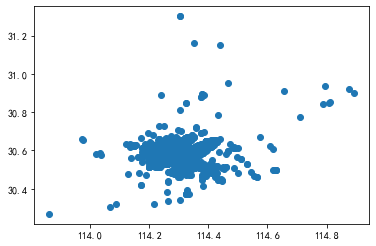

In [77]:
plt.scatter(weibodata['lng'],weibodata['lat'])

In [78]:
import folium
word_map=folium.Map()
word_map

In [46]:
center_lng=weibodata['lng'].mean()
center_lat=weibodata['lat'].mean()
print(center_lng,center_lat)
whmap=folium.Map(location=[center_lat,center_lng],zoom_start=12)
whmap

114.3091383848354 30.58619619176435


In [80]:
incidents = folium.map.FeatureGroup()
for lat, lng, in zip(weibodata.lat, weibodata.lng):
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=7, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.4
        )
    )
san_map = folium.Map(location=[center_lat, center_lng], zoom_start=12)
san_map.add_child(incidents)

In [81]:
latitudes = list(weibodata.lat)
longitudes = list(weibodata.lng)
labels = list(weibodata.addr)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(san_map)    
    
# add incidents to map
#san_map.add_child(incidents)

### 文件描述
由图可知，以长江两岸聚集分布

**Task4**: 确定求助者区县  
1. 利用经纬度反推所在区县（可调用百度 API      
2. 展示各区县的求助者数目(无求助者的不需展示

In [82]:
weibodata=pd.read_excel('lnglatdata.xlsx')
def Coord2Pos(lng,lat,town='true'):
    AK='iSYd2Nt62LU3OPFVH9twhnIDTkwF630Z'
    url='http://api.map.baidu.com/reverse_geocoding/v3/?output=json&ak=%s&location=%s,%s&extensions_town=%s' %(AK,lat,lng,town)
    response = requests.get(url)
    answer = response.json()
    #print(answer)
    return answer['result']['addressComponent']['district']
#Coord2Pos(118.81871976794395,31.88198449339288)
weibodata['district']=weibodata.apply(lambda x:Coord2Pos(x['lng'],x['lat']),axis=1)

In [83]:
weibodata.head()
weibodata.to_excel("lnglatdata.xlsx",index=False,header=True)

In [84]:
disdata = pd.DataFrame(weibodata['district'].value_counts())
disdata.reset_index(inplace=True)
disdata.rename(columns={'index':'district','district':'Count'},inplace=True)
disdata

district  Count
0       江岸区    256
1       洪山区    231
2       武昌区    231
3       硚口区    216
4       汉阳区    207
5       青山区    124
6       江汉区     97
7      东西湖区     44
8       江夏区     30
9       黄陂区     22
10      蔡甸区     13
11      新洲区     11
12      汉南区      3

#### 连接医院分布表分析
借助医院分布信息，挖掘医疗资源分布

**Task5**: 确定各区县医院分布        
1. 利用医院经纬度反推所在区县（可调用百度 API      
2. 打印各区县的医院数目（无医院的不需展示

In [85]:
###
hospital_data = pd.read_excel("poi_hospital.xlsx")
def Coord2Pos(lng,lat,town='true'):
    AK='iSYd2Nt62LU3OPFVH9twhnIDTkwF630Z'
    url='http://api.map.baidu.com/reverse_geocoding/v3/?output=json&ak=%s&location=%s,%s&extensions_town=%s' %(AK,lat,lng,town)
    response = requests.get(url)
    answer = response.json()
    #print(answer)
    return answer['result']['addressComponent']['district']
hospital_data['district']=hospital_data.apply(lambda x:Coord2Pos(x['lng'],x['lat']),axis=1)

In [86]:
hospital_data.head()
dishp = pd.DataFrame(hospital_data['district'].value_counts())
dishp.reset_index(inplace=True)
dishp.rename(columns={'index':'district','district':'Count'},inplace=True)
dishp

district  Count
0       武昌区     11
1       江岸区      8
2       硚口区      7
3       洪山区      6
4       青山区      6
5       江夏区      5
6       蔡甸区      5
7       江汉区      5
8       汉阳区      5
9      东西湖区      4
10      黄陂区      3
11      新洲区      3
12      汉南区      2

**Task6:** 确定患者到**最近医院**的距离     

1. 确定每位患者最近的医院及距离       
2. 任选一位患者，打印（患者所在区，医院所在区，医院名，距离）

Hint: 
    
1. 先利用球面距离估算可能的候选医院(候选)        
2. 利用 百度API 计算更精确的距离（步行）       
3. 如果你觉得配额足够且不在乎性能的话，请忽略以上提示          

In [87]:
import heapq

In [88]:
weibodata=pd.read_excel('lnglatdata.xlsx')

In [89]:
ls=weibodata.apply(lambda x:list( map( list(hospital_data.apply( lambda y: haversine_distance ( x['lat'],x['lng'],y['lat'],y['lng']),axis=1)).index, heapq.nsmallest(3, list( hospital_data.apply( lambda y:haversine_distance( x['lat'],x['lng'],y['lat'],y['lng']),axis=1))))),axis=1)

In [90]:
weibodata['hp']=ls
for i in range(3):
    weibodata['hpaddr'+str(i)]=weibodata['hp'].apply(lambda x: hospital_data.loc[x[i]]['hospital'])
    weibodata['lng'+str(i)]=weibodata['hp'].apply(lambda x: hospital_data.loc[x[i]]['lng'])
    weibodata['lat'+str(i)]=weibodata['hp'].apply(lambda x: hospital_data.loc[x[i]]['lat'])

In [91]:
weibodata.to_excel("lnglatdata.xlsx",index=False,header=True)
weibodata=pd.read_excel('lnglatdata.xlsx')
weibodata.head()
weibodata.describe()

name          age  link_lianjia_score          lng          lat  \
count  1485.000000  1485.000000         1485.000000  1485.000000  1485.000000   
mean    742.000000    58.973064            7.806646   114.309138    30.586196   
std     428.826888    15.785176            3.801770     0.083175     0.072160   
min       0.000000     3.000000           -1.000000   113.863346    30.268264   
25%     371.000000    50.000000            2.805690   114.258176    30.546644   
50%     742.000000    60.000000           10.000000   114.304578    30.588455   
75%    1113.000000    70.000000           10.000000   114.355646    30.622077   
max    1484.000000   100.000000           10.000000   114.891958    31.300945   

              lng0         lat0         lng1         lat1         lng2  \
count  1485.000000  1485.000000  1485.000000  1485.000000  1485.000000   
mean    114.311326    30.585277   114.312943    30.586124   114.311978   
std       0.077945     0.062044     0.074863     0.062079     0.074178   
min     114.033814    30.319436   114.033814    30.319436   114.050683   
25%     114.267206    30.552983   114.272054    30.550005   114.273049   
50%     114.304085    30.587029   114.304085    30.585720   114.304085   
75%     114.347663    30.630319   114.347663    30.619977   114.359069   
max     114.812080    30.894385   114.810169    30.894385   114.812080   

              lat2     minindex  
count  1485.000000  1485.000000  
mean     30.586085     0.129293  
std       0.059242     0.404803  
min      30.359306     0.000000  
25%      30.550005     0.000000  
50%      30.585720     0.000000  
75%      30.611914     0.000000  
max      30.894385     2.000000

In [92]:
weibodata=pd.read_excel('lnglatdata.xlsx')
import json

In [93]:
def getdistance(startlat,startlng,endlat,endlng):
    myAK='iSYd2Nt62LU3OPFVH9twhnIDTkwF630Z'
    distanceurl='http://api.map.baidu.com/directionlite/v1/walking?origin=%s,%s&destination=%s,%s&ak=%s'%(startlat,startlng,endlat,endlng,myAK)
    res = requests.get(distanceurl)
    dis_json_data = json.loads(res.text)
    distance=0
    if dis_json_data['status'] == 0:
        distance=dis_json_data['result']['routes'][0]['distance']
        #print(distance)
    return distance
getdistance(30.602611,114.208127,30.857793,114.81208)

74454

In [94]:
def mindistance(startlng,startlat,ls):
    res=[]
    for i in range(3):
        res.append(getdistance(startlat,startlng,ls[2*i+1],ls[2*i]))
    return res
ls=weibodata.apply(lambda x:mindistance(x['lng'],x['lat'],[x['lng0'],x['lat0'],x['lng1'],x['lat1'],x['lng2'],x['lat2']]),axis=1)
weibodata['mindistance']=ls

In [95]:
weibodata['minds']=weibodata['mindistance'].apply(lambda x:min(x))
weibodata['minindex']=weibodata['mindistance'].apply(lambda x:x.index(min(x)))
weibodata['minhp']=weibodata.apply(lambda x:x['hpaddr'+str(x['minindex'])],axis=1)
weibodata.head()

name  age city           addr    pubdate  link_lianjia_score  \
0     0   71   武汉        硚口区汉口春天   2020/2/8           10.000000   
1     1   43  武汉市    硚口区 古田路红星佳苑  2020/2/11            1.646069   
2     2   62   武汉       武胜路名仕阁小区   2020/2/8           10.000000   
3     3   10  武汉市  中南路付家坡小区付家坡二路  2020/2/16            2.289911   
4     4   36  武汉市       东西湖区恒大嘉园   2020/2/5           10.000000   

                                     lnglat         lng        lat district  \
0  (114.20812703287855, 30.602610902095677)  114.208127  30.602611      硚口区   
1      (114.1931413207, 30.600616008500406)  114.193141  30.600616      硚口区   
2   (114.2708555269792, 30.572608595939784)  114.270856  30.572609      硚口区   
3  (114.33936089984837, 30.538334234141775)  114.339361  30.538334      武昌区   
4  (114.12340047412735, 30.634288097131495)  114.123400  30.634288     东西湖区   

   ...       hpaddr1        lng1       lat1    hpaddr2        lng2       lat2  \
0  ...        武汉龙阳医院  114.217738  30.552983  湖北省第三人民医院  114.260511  30.575419   
1  ...        武汉龙阳医院  114.217738  30.552983    武汉市肺科医院  114.258584  30.587672   
2  ...       武汉市第四医院  114.273049  30.571961    武汉市第一医院  114.278513  30.578088   
3  ...  武汉科技大学附属天佑医院  114.337058  30.528712    武汉市第七医院  114.338093  30.548309   
4  ...   武汉市东西湖区人民医院  114.139361  30.655120     武汉太康医院  114.160525  30.643579   

          mindistance minindex       minhp  minds  
0  [6315, 7547, 6472]        0     武汉市肺科医院   6315  
1  [7456, 8398, 7908]        0      武汉太康医院   7456  
2    [445, 445, 1350]        0     武汉市第四医院    445  
3  [1044, 1470, 1541]        0  解放军中部战区总医院   1044  
4  [5410, 5410, 4918]        2      武汉太康医院   4918  

[5 rows x 24 columns]

In [96]:
weibodata.to_excel("lnglatdata.xlsx",index=False,header=True)

In [7]:
weibodata=pd.read_excel('lnglatdata.xlsx')
weibodata['minds']=weibodata['minds'].apply(lambda x:round(int(x)*1.0/1000,2))
weibodata[['name','minhp','minds']].to_csv('task6.csv',encoding='utf-8')

In [97]:
incidents = folium.map.FeatureGroup()
for lat, lng, in zip(weibodata.lat, weibodata.lng):
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=7, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.4
        )
    )
for lat, lng, in zip(hospital_data.lat, hospital_data.lng):
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=7, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='black',
            fill_opacity=0.4
        )
    )
san_map = folium.Map(location=[center_lat, center_lng], zoom_start=12)
san_map.add_child(incidents)

**Task7:** 各区县求助者距**最近医院**的距离分布    

1. 合并 Task4 和 Task6 的信息，即可确定分布    
2. 将分布展示并简要分析

In [60]:
###
weibodata=pd.read_excel('lnglatdata.xlsx')
dis=weibodata[['name','district','minds']]
dis

name district  minds
0        0      硚口区   6315
1        1      硚口区   7456
2        2      硚口区    445
3        3      武昌区   1044
4        4     东西湖区   4918
...    ...      ...    ...
1480  1480      江岸区    941
1481  1481      洪山区   4101
1482  1482      武昌区    535
1483  1483      江岸区   2021
1484  1484      汉阳区   1263

[1485 rows x 3 columns]

In [52]:
import matplotlib as mpl
mpl.rcParams['font.family']='SimHei'
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False     # 正常显示负号

In [53]:
dis.pivot('name','district','minds')

district    东西湖区  新洲区     武昌区  汉南区     汉阳区  江夏区     江岸区  江汉区     洪山区     硚口区  \
name                                                                           
0            NaN  NaN     NaN  NaN     NaN  NaN     NaN  NaN     NaN  6315.0   
1            NaN  NaN     NaN  NaN     NaN  NaN     NaN  NaN     NaN  7456.0   
2            NaN  NaN     NaN  NaN     NaN  NaN     NaN  NaN     NaN   445.0   
3            NaN  NaN  1044.0  NaN     NaN  NaN     NaN  NaN     NaN     NaN   
4         4918.0  NaN     NaN  NaN     NaN  NaN     NaN  NaN     NaN     NaN   
...          ...  ...     ...  ...     ...  ...     ...  ...     ...     ...   
1480         NaN  NaN     NaN  NaN     NaN  NaN   941.0  NaN     NaN     NaN   
1481         NaN  NaN     NaN  NaN     NaN  NaN     NaN  NaN  4101.0     NaN   
1482         NaN  NaN   535.0  NaN     NaN  NaN     NaN  NaN     NaN     NaN   
1483         NaN  NaN     NaN  NaN     NaN  NaN  2021.0  NaN     NaN     NaN   
1484         NaN  NaN     NaN  NaN  1263.0  NaN     NaN  NaN     NaN     NaN   

district  蔡甸区  青山区  黄陂区  
name                     
0         NaN  NaN  NaN  
1         NaN  NaN  NaN  
2         NaN  NaN  NaN  
3         NaN  NaN  NaN  
4         NaN  NaN  NaN  
...       ...  ...  ...  
1480      NaN  NaN  NaN  
1481      NaN  NaN  NaN  
1482      NaN  NaN  NaN  
1483      NaN  NaN  NaN  
1484      NaN  NaN  NaN  

[1485 rows x 13 columns]

array([[<AxesSubplot:title={'center':'东西湖区'}>,
        <AxesSubplot:title={'center':'新洲区'}>,
        <AxesSubplot:title={'center':'武昌区'}>,
        <AxesSubplot:title={'center':'汉南区'}>],
       [<AxesSubplot:title={'center':'汉阳区'}>,
        <AxesSubplot:title={'center':'江夏区'}>,
        <AxesSubplot:title={'center':'江岸区'}>,
        <AxesSubplot:title={'center':'江汉区'}>],
       [<AxesSubplot:title={'center':'洪山区'}>,
        <AxesSubplot:title={'center':'硚口区'}>,
        <AxesSubplot:title={'center':'蔡甸区'}>,
        <AxesSubplot:title={'center':'青山区'}>],
       [<AxesSubplot:title={'center':'黄陂区'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

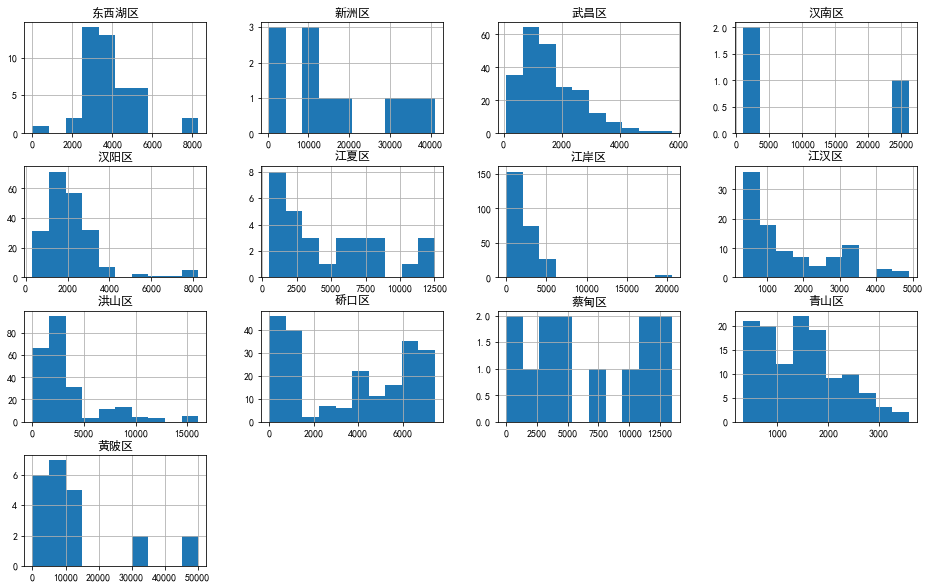

In [54]:
dis.pivot('name','district','minds').hist(figsize=(16,10),bins=10)

In [ ]:
y_axis = ["<1", "1<=s", "Thursday", "Wednesday", "Tuesday", "Monday", "Sunday"]

# 热力图待续
import random
from pyecharts import HeatMap

heatmap = HeatMap()
heatmap.add(
    "热力图直角坐标系",
    weibodata['distract'],
    weibodata['mindis'],
    data,
    is_visualmap=True,
    visual_text_color="#000",
    visual_orient="horizontal",
)
heatmap.render()

**Task8**: 估算各区县求助者得到医院有效服务的数目          
1. 假设每位患者能被周围 3km 的医院服务，计算对应医院数目         
2. 合并患者所在区县和上述信息，展示并简要分析     

In [59]:
weibodata.head()
hospital_data.head()

hospital type         lng        lat
0            中部战区总医院（汉口院区）   发热  114.314594  30.619972
1        华中科技大学同济医学院附属协和医院   发热  114.281297  30.590143
2        华中科技大学同济医学院附属同济医院   发热  114.267206  30.585720
3  华中科技大学同济医学院附属同济医院（光谷院区）   发热  114.470327  30.493164
4         华中科技大学同济医院附属梨园医院   发热  114.384108  30.585202

array([[<AxesSubplot:title={'center':'东西湖区'}>,
        <AxesSubplot:title={'center':'新洲区'}>,
        <AxesSubplot:title={'center':'武昌区'}>,
        <AxesSubplot:title={'center':'汉南区'}>],
       [<AxesSubplot:title={'center':'汉阳区'}>,
        <AxesSubplot:title={'center':'江夏区'}>,
        <AxesSubplot:title={'center':'江岸区'}>,
        <AxesSubplot:title={'center':'江汉区'}>],
       [<AxesSubplot:title={'center':'洪山区'}>,
        <AxesSubplot:title={'center':'硚口区'}>,
        <AxesSubplot:title={'center':'蔡甸区'}>,
        <AxesSubplot:title={'center':'青山区'}>],
       [<AxesSubplot:title={'center':'黄陂区'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

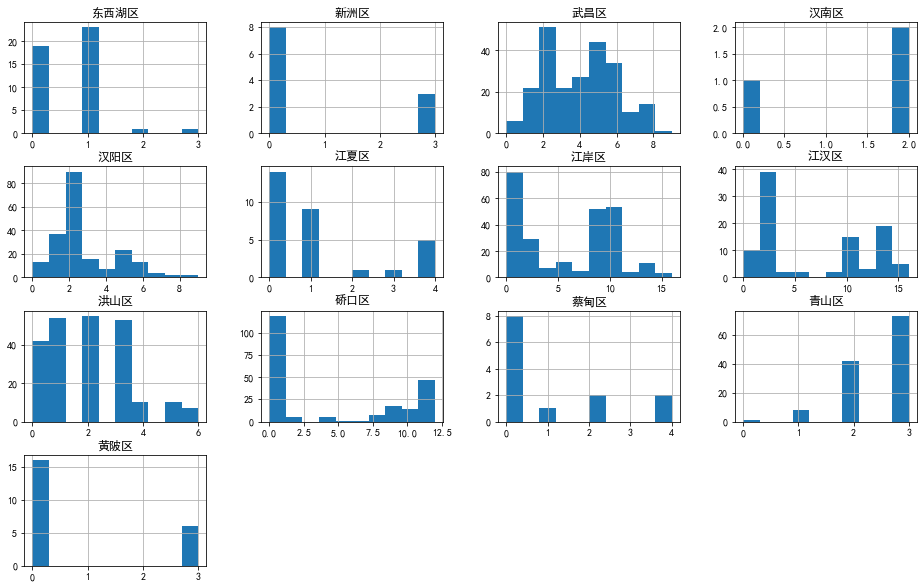

In [65]:
###
ls=weibodata.apply(lambda x: sum(list(hospital_data.apply(lambda y:int(haversine_distance(x['lat'],x['lng'],y['lat'],y['lng'])<3.0),axis=1) )),axis=1)
weibodata['hpnum']=ls
weibodata.pivot('name','district','hpnum').hist(figsize=(16,10),bins=10)

# 热力图待续

**Task9**: 估算医疗资源覆盖利用情况          
1. 将以患者为中心改为以医院为中心，         
2. 计算每个医院 3km 能覆盖的患者数目            
3. 根据医院患者数目降序排序，展示前10个医院        

In [62]:
weibodata.head()

name  age city           addr    pubdate  link_lianjia_score  \
0     0   71   武汉        硚口区汉口春天   2020/2/8           10.000000   
1     1   43  武汉市    硚口区 古田路红星佳苑  2020/2/11            1.646069   
2     2   62   武汉       武胜路名仕阁小区   2020/2/8           10.000000   
3     3   10  武汉市  中南路付家坡小区付家坡二路  2020/2/16            2.289911   
4     4   36  武汉市       东西湖区恒大嘉园   2020/2/5           10.000000   

                                     lnglat         lng        lat district  \
0  (114.20812703287855, 30.602610902095677)  114.208127  30.602611      硚口区   
1      (114.1931413207, 30.600616008500406)  114.193141  30.600616      硚口区   
2   (114.2708555269792, 30.572608595939784)  114.270856  30.572609      硚口区   
3  (114.33936089984837, 30.538334234141775)  114.339361  30.538334      武昌区   
4  (114.12340047412735, 30.634288097131495)  114.123400  30.634288     东西湖区   

   ...       hpaddr1        lng1       lat1    hpaddr2        lng2       lat2  \
0  ...        武汉龙阳医院  114.217738  30.552983  湖北省第三人民医院  114.260511  30.575419   
1  ...        武汉龙阳医院  114.217738  30.552983    武汉市肺科医院  114.258584  30.587672   
2  ...       武汉市第四医院  114.273049  30.571961    武汉市第一医院  114.278513  30.578088   
3  ...  武汉科技大学附属天佑医院  114.337058  30.528712    武汉市第七医院  114.338093  30.548309   
4  ...   武汉市东西湖区人民医院  114.139361  30.655120     武汉太康医院  114.160525  30.643579   

          mindistance minindex       minhp  minds  
0  [6315, 7547, 6472]        0     武汉市肺科医院   6315  
1  [7456, 8398, 7908]        0      武汉太康医院   7456  
2    [445, 445, 1350]        0     武汉市第四医院    445  
3  [1044, 1470, 1541]        0  解放军中部战区总医院   1044  
4  [5410, 5410, 4918]        2      武汉太康医院   4918  

[5 rows x 24 columns]

In [70]:
hospital_data['num']=hospital_data.apply(lambda x: sum(list(weibodata.apply(lambda y:int(haversine_distance(x['lat'],x['lng'],y['lat'],y['lng'])<3.0),axis=1) )),axis=1)

array([[<AxesSubplot:title={'center':'东西湖区人民医院'}>,
        <AxesSubplot:title={'center':'中部战区总医院（汉口院区）'}>,
        <AxesSubplot:title={'center':'华中科技大学同济医学院附属协和医院'}>,
        <AxesSubplot:title={'center':'华中科技大学同济医学院附属协和医院（西院）'}>,
        <AxesSubplot:title={'center':'华中科技大学同济医学院附属同济医院'}>,
        <AxesSubplot:title={'center':'华中科技大学同济医学院附属同济医院（中法新城院区）'}>,
        <AxesSubplot:title={'center':'华中科技大学同济医学院附属同济医院（光谷院区）'}>,
        <AxesSubplot:title={'center':'华中科技大学同济医院附属梨园医院'}>],
       [<AxesSubplot:title={'center':'华润武钢总医院'}>,
        <AxesSubplot:title={'center':'新洲区人民医院'}>,
        <AxesSubplot:title={'center':'武汉亚心总医院'}>,
        <AxesSubplot:title={'center':'武汉亚洲心脏病医院'}>,
        <AxesSubplot:title={'center':'武汉大学人民医院'}>,
        <AxesSubplot:title={'center':'武汉大学人民医院（东院）'}>,
        <AxesSubplot:title={'center':'武汉太康医院'}>,
        <AxesSubplot:title={'center':'武汉市东西湖区人民医院'}>],
       [<AxesSubplot:title={'center':'武汉市中医医院'}>,
        <AxesSubplot:title={'center':'武汉市中医医院（汉阳院区）'}

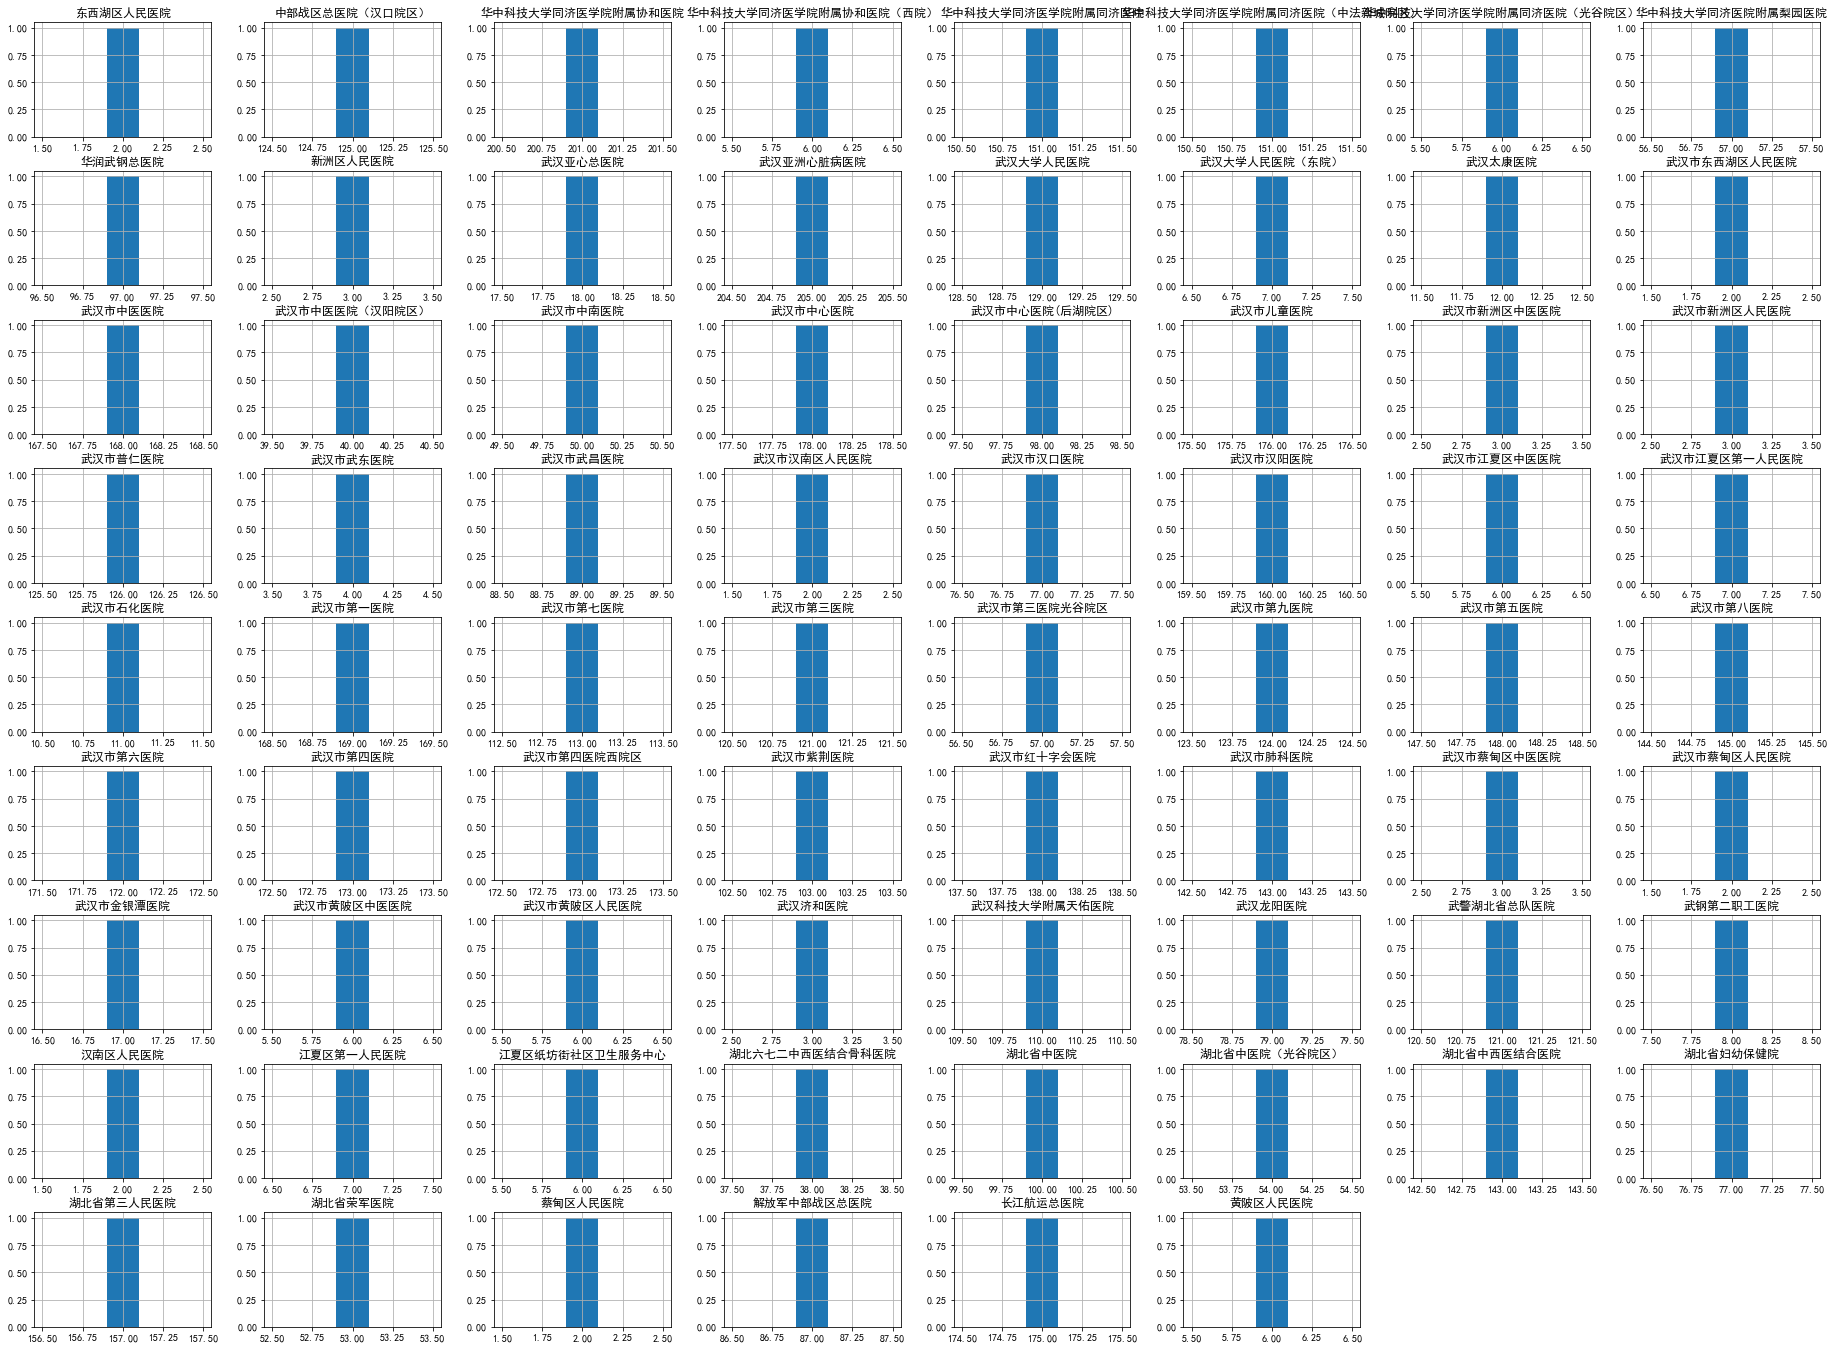

In [73]:
### 
hospital_data.reset_index().pivot('index','hospital','num').hist(figsize=(32,24),bins=5)

In [84]:
hospital_data.sort_values(by=['num'],axis=0,ascending=[False],inplace=True)
hospital_data.reset_index(inplace=True)
hospital_data.head(10)

level_0  index           hospital type         lng        lat  num
0        0      7          武汉亚洲心脏病医院   发热  114.288865  30.588780  205
1        1      1  华中科技大学同济医学院附属协和医院   发热  114.281297  30.590143  201
2        2     13            武汉市中心医院   发热  114.301489  30.586825  178
3        3     14            武汉市儿童医院   发热  114.295549  30.608173  176
4        4     41            长江航运总医院   发热  114.294641  30.611914  175
5        5     27            武汉市第四医院   发热  114.273049  30.571961  173
6        6     56         武汉市第四医院西院区   定点  114.273049  30.571961  173
7        7     55            武汉市第六医院   定点  114.296889  30.605761  172
8        8     24            武汉市第一医院   发热  114.278513  30.578088  169
9        9     11            武汉市中医医院   发热  114.304382  30.594185  168

#### 连接链家小区表分析
## 结合链家小区的房价、年份信息，进一步挖掘信息


**Task10:** 确定患者所在小区

1.  如题面，比如说将“武昌区积玉桥四清里社区嘉景花园”匹配到“武昌区 嘉景花园”，具体方法不限
2.  某些地址可能无法确定对应小区，可以忽略。

Hint:

1. 建议主要使用基于规则的字符串匹配，则建议
    1. 将地名预处理规范化，“武昌区积玉桥四清里社区嘉景花园” -> ("武昌区", "积玉桥", "四清里社区", "嘉景花园")
    2. 根据规范化后的地名尝试字符串匹配
2. 可以尝试使用 编辑距离、Jaccard距离、TFIDF向量距离 等辅助计算地名相似度
3. 特别的，本实验偏工程，不必指望用同一套方法完成所有的匹配，可以分别处理，即先用 A 方法匹配一部分，剩下的再尝试使用 B、C等方法。

In [3]:
weibodata=pd.read_excel('lnglatdata.xlsx')
weibodata.head()

name  age city           addr    pubdate  link_lianjia_score  \
0     0   71   武汉        硚口区汉口春天   2020/2/8           10.000000   
1     1   43  武汉市    硚口区 古田路红星佳苑  2020/2/11            1.646069   
2     2   62   武汉       武胜路名仕阁小区   2020/2/8           10.000000   
3     3   10  武汉市  中南路付家坡小区付家坡二路  2020/2/16            2.289911   
4     4   36  武汉市       东西湖区恒大嘉园   2020/2/5           10.000000   

                                     lnglat         lng        lat district  \
0  (114.20812703287855, 30.602610902095677)  114.208127  30.602611      硚口区   
1      (114.1931413207, 30.600616008500406)  114.193141  30.600616      硚口区   
2   (114.2708555269792, 30.572608595939784)  114.270856  30.572609      硚口区   
3  (114.33936089984837, 30.538334234141775)  114.339361  30.538334      武昌区   
4  (114.12340047412735, 30.634288097131495)  114.123400  30.634288     东西湖区   

   ...       hpaddr1        lng1       lat1    hpaddr2        lng2       lat2  \
0  ...        武汉龙阳医院  114.217738  30.552983  湖北省第三人民医院  114.260511  30.575419   
1  ...        武汉龙阳医院  114.217738  30.552983    武汉市肺科医院  114.258584  30.587672   
2  ...       武汉市第四医院  114.273049  30.571961    武汉市第一医院  114.278513  30.578088   
3  ...  武汉科技大学附属天佑医院  114.337058  30.528712    武汉市第七医院  114.338093  30.548309   
4  ...   武汉市东西湖区人民医院  114.139361  30.655120     武汉太康医院  114.160525  30.643579   

          mindistance minindex       minhp  minds  
0  [6315, 7547, 6472]        0     武汉市肺科医院   6315  
1  [7456, 8398, 7908]        0      武汉太康医院   7456  
2    [445, 445, 1350]        0     武汉市第四医院    445  
3  [1044, 1470, 1541]        0  解放军中部战区总医院   1044  
4  [5410, 5410, 4918]        2      武汉太康医院   4918  

[5 rows x 24 columns]

In [57]:
###
import json
from urllib.request import urlopen, quote
import requests

def getstr(lat,lng):
    #http://api.map.baidu.com/place/v2/search?query=银行&location=39.915,116.404&radius=2000&output=xml&ak=您的密钥 //GET请求
    AK='iSYd2Nt62LU3OPFVH9twhnIDTkwF630Z'
    url='http://api.map.baidu.com/place/v2/search?query=住宅区&location=%s,%s&radius=1000&output=json&ak=%s' %(lat,lng,AK)
    response = requests.get(url)
    answer = response.json()
    if len(answer['results'])==0:
        return '信息缺失'
    #print(answer)
    return answer['results'][0]['area']+' '+answer['results'][0]['name']
getstr(30.538334,114.339361)

'武昌区 付家坡二路8号3栋-1单元'

In [6]:
weibodata['area']=weibodata.apply(lambda x:getstr(x['lat'],x['lng']),axis=1)

In [8]:
weibodata.head()

name  age city           addr    pubdate  link_lianjia_score  \
0     0   71   武汉        硚口区汉口春天   2020/2/8           10.000000   
1     1   43  武汉市    硚口区 古田路红星佳苑  2020/2/11            1.646069   
2     2   62   武汉       武胜路名仕阁小区   2020/2/8           10.000000   
3     3   10  武汉市  中南路付家坡小区付家坡二路  2020/2/16            2.289911   
4     4   36  武汉市       东西湖区恒大嘉园   2020/2/5           10.000000   

                                     lnglat         lng        lat district  \
0  (114.20812703287855, 30.602610902095677)  114.208127  30.602611      硚口区   
1      (114.1931413207, 30.600616008500406)  114.193141  30.600616      硚口区   
2   (114.2708555269792, 30.572608595939784)  114.270856  30.572609      硚口区   
3  (114.33936089984837, 30.538334234141775)  114.339361  30.538334      武昌区   
4  (114.12340047412735, 30.634288097131495)  114.123400  30.634288     东西湖区   

   ...        lng1       lat1    hpaddr2        lng2       lat2  \
0  ...  114.217738  30.552983  湖北省第三人民医院  114.260511  30.575419   
1  ...  114.217738  30.552983    武汉市肺科医院  114.258584  30.587672   
2  ...  114.273049  30.571961    武汉市第一医院  114.278513  30.578088   
3  ...  114.337058  30.528712    武汉市第七医院  114.338093  30.548309   
4  ...  114.139361  30.655120     武汉太康医院  114.160525  30.643579   

          mindistance  minindex       minhp  minds               area  
0  [6315, 7547, 6472]         0     武汉市肺科医院   6315           硚口区 汉口春天  
1  [7456, 8398, 7908]         0      武汉太康医院   7456     硚口区 金地悦江时代-1号楼  
2    [445, 445, 1350]         0     武汉市第四医院    445          硚口区 名仕阁小区  
3  [1044, 1470, 1541]         0  解放军中部战区总医院   1044  武昌区 付家坡二路8号3栋-1单元  
4  [5410, 5410, 4918]         2      武汉太康医院   4918          东西湖区 恒大嘉园  

[5 rows x 25 columns]

In [9]:
#weibodata.drop(['hpaddr1','lng1','lat1','hpaddr2','hpaddr2','lng2','lat2'],axis=1,inplace=True)
weibodata.to_excel('ljdata.xlsx')

In [11]:
weibodata=pd.read_excel('ljdata.xlsx')
weibodata[['name','area']].

**Task11**: 比较患者小区分布与整体分布

1. 绘制展示患者小区房价分布、武汉市整体房价分布，作简要分析。
2. 针对建造年份，重复上述过程比较分布情况。

In [16]:
###
import Levenshtein
lianjia_data = pd.read_excel("new_lianjia.xlsx")
area=''
price=0
year=0
cmp=0
for item in lianjia_data.itertuples():
    #print(item[1])
    tmp=Levenshtein.ratio('汉口春天',item[1])
    if tmp>cmp:
        cmp=tmp
        area=item[1]
        price=item[-1]
        year=item[4]
print(area,price,year)

硚口区 汉口春天 17848 2007


In [18]:
lslj=[]
lsprice=[]
lsyear=[]
for line in weibodata.itertuples():
    area=''
    price=0
    year=0
    cmp=0
    for item in lianjia_data.itertuples():
        tmp=Levenshtein.ratio(line[-1],item[1])
        if tmp>cmp:
            cmp=tmp
            area=item[1]
            price=item[-1]
            year=item[4]
    lslj.append(area)
    lsprice.append(price)
    lsyear.append(year)

In [27]:
weibodata['price']=lsprice
weibodata['year']=lsyear
weibodata.to_excel('ljdata.xlsx')
weibodata.head()

name  age city           addr    pubdate  link_lianjia_score  \
0     0   71   武汉        硚口区汉口春天   2020/2/8           10.000000   
1     1   43  武汉市    硚口区 古田路红星佳苑  2020/2/11            1.646069   
2     2   62   武汉       武胜路名仕阁小区   2020/2/8           10.000000   
3     3   10  武汉市  中南路付家坡小区付家坡二路  2020/2/16            2.289911   
4     4   36  武汉市       东西湖区恒大嘉园   2020/2/5           10.000000   

                                     lnglat         lng        lat district  \
0  (114.20812703287855, 30.602610902095677)  114.208127  30.602611      硚口区   
1      (114.1931413207, 30.600616008500406)  114.193141  30.600616      硚口区   
2   (114.2708555269792, 30.572608595939784)  114.270856  30.572609      硚口区   
3  (114.33936089984837, 30.538334234141775)  114.339361  30.538334      武昌区   
4  (114.12340047412735, 30.634288097131495)  114.123400  30.634288     东西湖区   

   ...    hpaddr2        lng2       lat2         mindistance minindex  \
0  ...  湖北省第三人民医院  114.260511  30.575419  [6315, 7547, 6472]        0   
1  ...    武汉市肺科医院  114.258584  30.587672  [7456, 8398, 7908]        0   
2  ...    武汉市第一医院  114.278513  30.578088    [445, 445, 1350]        0   
3  ...    武汉市第七医院  114.338093  30.548309  [1044, 1470, 1541]        0   
4  ...     武汉太康医院  114.160525  30.643579  [5410, 5410, 4918]        2   

        minhp  minds               area  price  year  
0     武汉市肺科医院   6315           硚口区 汉口春天  17848  2007  
1      武汉太康医院   7456     硚口区 金地悦江时代-1号楼  19420  2019  
2     武汉市第四医院    445          硚口区 名仕阁小区  18161  1995  
3  解放军中部战区总医院   1044  武昌区 付家坡二路8号3栋-1单元  21249  1983  
4      武汉太康医院   4918          东西湖区 恒大嘉园  12880  2017  

[5 rows x 27 columns]

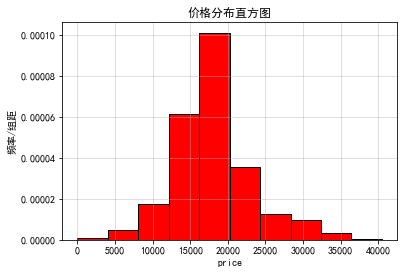

In [22]:

plt.rcParams['font.sans-serif']=[u'SimHei']
plt.hist(weibodata['price'],bins=10,density=True,facecolor='red',edgecolor='black',rwidth=8)
plt.grid(alpha = 0.5)
plt.xlabel('price')
plt.ylabel('频率/组距')
plt.title('患者价格分布直方图')
plt.show()

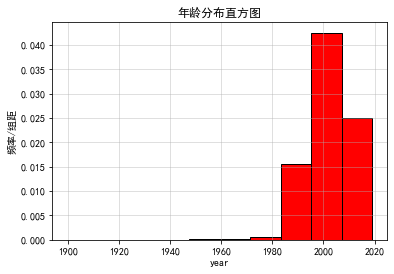

In [23]:
plt.rcParams['font.sans-serif']=[u'SimHei']
plt.hist(weibodata['year'],bins=10,density=True,facecolor='red',edgecolor='black',rwidth=8)
plt.grid(alpha = 0.5)
plt.xlabel('year')
plt.ylabel('频率/组距')
plt.title('年龄分布直方图')
plt.show()

C:\Python39\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


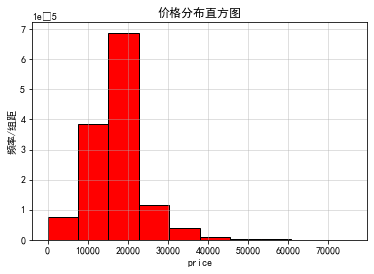

In [24]:
plt.rcParams['font.sans-serif']=[u'SimHei']
plt.hist(lianjia_data['est_price'],bins=10,density=True,facecolor='red',edgecolor='black',rwidth=8)
plt.grid(alpha = 0.5)
plt.xlabel('price')
plt.ylabel('频率/组距')
plt.title('价格分布直方图')
plt.show()

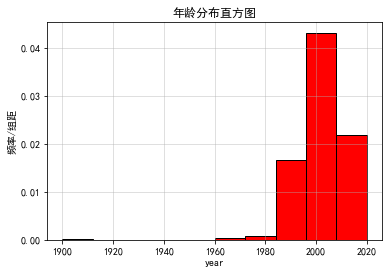

In [25]:
plt.rcParams['font.sans-serif']=[u'SimHei']
plt.hist(lianjia_data['year'],bins=10,density=True,facecolor='red',edgecolor='black',rwidth=8)
plt.grid(alpha = 0.5)
plt.xlabel('year')
plt.ylabel('频率/组距')
plt.title('年龄分布直方图')
plt.show()

# 结论：没有区别

### 自选角度分析

此处为自选角度，利用已有数据或者自行补充的数据进行分析并且得出结论

# 分析疫情下武汉新建的医院的地理位置及信息和处理
# （以方舱医院和雷神山、火神山为例）

In [ ]:
数据：武汉市东西湖区将军路街金银潭大道与宏图路交汇

In [26]:
###
import json
from urllib.request import urlopen, quote
import requests

def getlnglat(address):
    url = 'http://api.map.baidu.com/geocoding/v3/'
    output = 'json'
    city = '武汉市'
    ak = 'iSYd2Nt62LU3OPFVH9twhnIDTkwF630Z'
    uri = url + '?' + 'address=' + address +'&city=' +city + '&output=' + output + '&ak=' + ak 
    req = requests.get(uri)
    r = json.loads(req.text)
    #print(r)
    lng=r['result']['location']['lng']
    lat=r['result']['location']['lat']
    return lng,lat

In [32]:
newhp=pd.read_excel("newhp.xlsx")
newhp.head()

addr  lng  lat
0  武汉客厅会展中心  NaN  NaN
1     武汉体育馆  NaN  NaN
2  武汉国际会展中心  NaN  NaN
3   武汉洪山体育馆  NaN  NaN
4    黄坡区体育馆  NaN  NaN

In [41]:
newhpls=newhp['addr'].apply(getlnglat)

In [43]:
newhp['lnglat']=newhpls
nhpls=list(map(list,zip(*newhpls)))
newhp['lng']=nhpls[0]
newhp['lat']=nhpls[1]
newhp.head()

addr         lng        lat                                    lnglat
0  武汉客厅会展中心  114.290170  30.675284   (114.29016999374925, 30.67528409894816)
1     武汉体育馆  114.266616  30.582881   (114.26661615378596, 30.58288099445771)
2  武汉国际会展中心  114.280240  30.585599  (114.28023994498083, 30.585598694636374)
3   武汉洪山体育馆  114.394421  30.618637  (114.39442086343762, 30.618637085083105)
4    黄坡区体育馆  114.394421  30.618637  (114.39442086343762, 30.618637085083105)

In [86]:
import folium

incidents = folium.map.FeatureGroup()
for lat, lng, in zip(weibodata.lat, weibodata.lng):
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=7, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.4
        )
    )
for lat, lng, in zip(hospital_data.lat, hospital_data.lng):
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=7, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='black',
            fill_opacity=0.4
        )
    )
san_map = folium.Map(location=[center_lat, center_lng], zoom_start=12)

latitudes = list(newhp.lat)
longitudes = list(newhp.lng)
labels = list(newhp.addr)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(san_map)

san_map.add_child(incidents)

# 结论：可以看见新建的方舱医院主要分布在人口密集的地区，用以提供较好的帮助，火神山在人群密集地区，而雷神山分布在人群稀少地区，分别处理不同地区的情况。

# 为了抗击疫情

# 各行各业都倾尽自己最大的努力

# 20年初为了不让“人等床“

# 武汉将其最大的会展中心、体育馆

# 以最快的速度改造成为方舱医院

# 让数以万计的患者得到隔离治疗

# 原本提供商业、文娱活动的场所

# 在人民需要的时候也能拯救生命

# 这些堪当重任的场地也应该被人们所了解